In [2]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from numpy import *

from ggplot import *
from scipy.stats import logistic
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import *
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC, SVR
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


from linearmodels.iv import IV2SLS
from scipy import stats
from scipy.stats import trim_mean #trimmed mean
from scipy.stats import * #chi2_contingency로 카이제곱통계량계산
from scipy.stats import norm

import keyword
import random

#open api 불러올 때 필요한 것
from urllib.request import urlopen #request package 설치
from bs4 import BeautifulSoup #bs4 package 설치

# 그래프에서 한글 깨지지 않기 위헤 사용함
from matplotlib import rcParams
from matplotlib import font_manager,rc

rcParams['axes.unicode_minus']=False
plt.rcParams['font.family']='Malgun Gothic'
font_name=font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family=font_name)

import FinanceDataReader as fdr
import plotly.graph_objects as go
import plotly.subplots as ms
import math

import tensorflow as tf

import qgrid

# 1. Lecture 13 회귀분석과 머신러닝(2)
## 1.1 머신러닝을 이용한 주택가격 추정
- (아래) 시계열 데이터임
- 과거 벌어진 일이 현재 영향을 줌. 동적 모형. 시계열 데이터에서는 흔한 상황임



In [4]:
df=pd.read_csv('c:/temp/HPI_SEOUL.csv',encoding='CP949')

df1=df[['API_TT0','GU_CODE2','BaseRate','IND_INDEX','LTV','DTI','FREQ']]
df2=df1.copy()

df2['BaseRate1']=df2.groupby('GU_CODE2')['BaseRate'].shift(1)
df2['IND_INDEX1']=df2.groupby('GU_CODE2')['IND_INDEX'].shift(1)
df2['LTV2']=df2.groupby('GU_CODE2')['LTV'].shift(2)
df2['DTI2']=df2.groupby('GU_CODE2')['DTI'].shift(2)

df3=df2.dropna()
df3.head()

,API_TT0,GU_CODE2,BaseRate,IND_INDEX,LTV,DTI,FREQ,BaseRate1,IND_INDEX1,LTV2,DTI2
2,81.208640,1111,4.5,123.203,44.425621,94.000000,90,4.25,99.469,42.912677,93.255607
3,88.068940,1111,4.5,128.718,50.340131,95.151515,99,4.50,123.203,43.944172,94.827586
4,86.507762,1111,4.5,110.893,50.951451,48.890836,68,4.50,128.718,44.425621,94.000000
5,91.769299,1111,4.5,102.227,51.251565,48.351863,48,4.50,110.893,50.340131,95.151515
6,92.079847,1111,5.0,108.332,52.053270,48.055339,55,4.50,102.227,50.951451,48.890836


In [5]:
qgrid_widget=qgrid.show_grid(df3,show_toolbar=True)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## 1.1.1 OLS
- 위에 df3 가지고 하면 ols. 앞 강의 참조

## 1.1.2 ML
- 시계열 데이터 분석
- 텐서플로우 사용
- 이 아래 사용해서 ML 함

In [7]:
X=df3[['BaseRate1','IND_INDEX1','LTV2','DTI2']].to_numpy()
X=X.astype('float32') # 텐서에서 사용하려면 float32로 바꿔야 함
k=X.shape[1] # x변수 숫자만 큼 k 생성

y=df3[['API_TT0']].to_numpy()
y=y.astype('float32')

In [8]:
# cf. ols 로 추정할 떄는 dataframe 구조 그대로 써야한다

In [9]:
tf.random.set_seed(225) # 초기값을 주기 위해서 난수를 배정한다
W=tf.Variable(tf.random.normal((k,1))) # x 변수의 coef : 정규분포에서 값을 무작위로 준다
b=tf.Variable(tf.random.normal([1])) #

loss=[]
learning_rate=tf.Variable(0.00001) # 지난 시간에 이걸 너무 크게 줘서 저번시간에 문제가 생김

for i in range(1000+1):
    with tf.GradientTape() as tape:
        hypothesis=tf.matmul(X,W)+b # X: n x k 행렬, W는 k x 1 벡터 / tf.matmul: 행렬 곱
        cost=tf.reduce_mean(tf.square(hypothesis-y))
        loss.append(cost.numpy()) # cost function의 값을 loss에 모은다. 나중에 그래프 그려볼라고
        
        W_grad, b_grad=tape.gradient(cost,[W,b]) #경사 찾기 위해 미분
        
        W.assign_sub(learning_rate*W_grad) # 경사 update 천번동안
        b.assign_sub(learning_rate*b_grad)
    
    if i % 100==0: # 1000번 중 100번 200 번 ... 마다만 값 보여줘라
        print(cost.numpy(),W.numpy().flatten(),b.numpy()) # .flatten() : 값 아래로 말고 옆으로 나오게 함

18818.78 [-0.51187295 -0.82557464  0.98306465  0.62890476] [1.1993473]
220.06773 [-0.48506594 -0.10185054  1.255872    0.5248685 ] [1.2058413]
139.99258 [-0.4737022   0.05015438  1.2401663   0.2919946 ] [1.2072456]
110.76241 [-0.46432987  0.14730291  1.2148523   0.1569237 ] [1.2083426]
99.40967 [-0.45636198  0.2113026   1.1858472   0.07904403] [1.209263]
94.50186 [-0.449426    0.25500518  1.1563874   0.03455216] [1.2100827]
92.03804 [-0.44327852  0.2860531   1.1281654   0.00950321] [1.2108462]
90.590096 [-0.43775487  0.3090195   1.1019934  -0.00426668] [1.2115785]
89.62695 [-0.43273917  0.32666624  1.0781896  -0.01153184] [1.2122946]
88.93524 [-0.42814648  0.34068385  1.0567989  -0.01507949] [1.2130008]
88.41784 [-0.4239121   0.3521253   1.0377243  -0.01653283] [1.2137041]


In [10]:
# 맨 윗줄은 초기값
# 그 아래부터 100번째 결과값, 200번째 결과값, 300번째 결과값, ... 등
# 220.06773 [-0.48506594 -0.10185054  1.255872    0.5248685 ] [1.2058413]
# cost function 값 (계속 minimize 되고 있다) / base rate의 효과 / 경기 효과 / ltv / dti / 상수항 bias 의 챋ㄹ
# cost func 많이 줄어들다가 끝에는 적게 줄어들고 있다

In [11]:
# cosf function 줄어드는 모양을 그래프로 그려보자
# 먼저 loss에 쌓여있는 cost func 값을 보자
loss

[18818.78,
 7695.478,
 3302.277,
 1565.8752,
 878.29456,
 604.76855,
 494.71704,
 449.22046,
 429.2291,
 419.3275,
 413.43002,
 409.13394,
 405.49072,
 402.12567,
 398.8904,
 395.72662,
 392.61038,
 389.5329,
 386.4898,
 383.4795,
 380.50104,
 377.5538,
 374.63754,
 371.7518,
 368.8963,
 366.07056,
 363.2744,
 360.50754,
 357.76947,
 355.06012,
 352.3791,
 349.72604,
 347.10086,
 344.5029,
 341.93216,
 339.38837,
 336.8709,
 334.38,
 331.915,
 329.47565,
 327.06186,
 324.6732,
 322.30957,
 319.97052,
 317.65588,
 315.36554,
 313.09885,
 310.856,
 308.63632,
 306.44,
 304.26642,
 302.11548,
 299.98712,
 297.88086,
 295.79654,
 293.73383,
 291.69278,
 289.67294,
 287.674,
 285.69608,
 283.73862,
 281.80154,
 279.88458,
 277.98767,
 276.11044,
 274.25272,
 272.41434,
 270.59512,
 268.79474,
 267.0131,
 265.25,
 263.5052,
 261.77853,
 260.0698,
 258.3788,
 256.70538,
 255.04932,
 253.41049,
 251.7887,
 250.18362,
 248.59528,
 247.0234,
 245.46785,
 243.92842,
 242.40489,
 240.89722,
 239.4

In [13]:
# cosf function 줄어드는 모양을 그래프로 그려보자
loss_data=pd.Series(loss) # loss는 array 구조였으니까, data frame으로 일단 바꾸자. 
loss_data

0       18818.779297
1        7695.478027
2        3302.277100
3        1565.875244
4         878.294556
            ...     
996        88.435921
997        88.431396
998        88.426872
999        88.422340
1000       88.417839
Length: 1001, dtype: float32

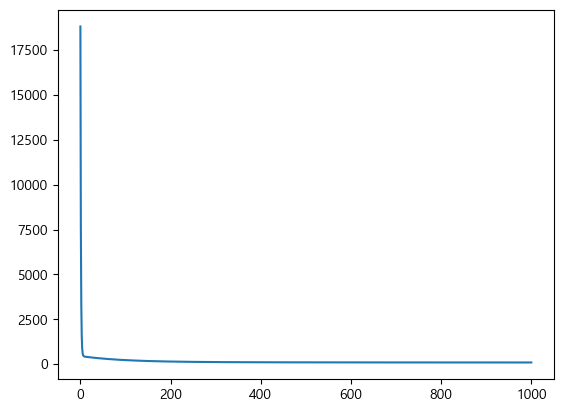

In [14]:
plt.plot(loss_data)
plt.grid
plt.show()

In [16]:
# 100 ~ 1000번 만 잘라서 그리자
loss_data1=loss_data.loc[100:1000]
loss_data1

100     220.067734
101     218.791199
102     217.527939
103     216.277618
104     215.040253
           ...    
996      88.435921
997      88.431396
998      88.426872
999      88.422340
1000     88.417839
Length: 901, dtype: float32

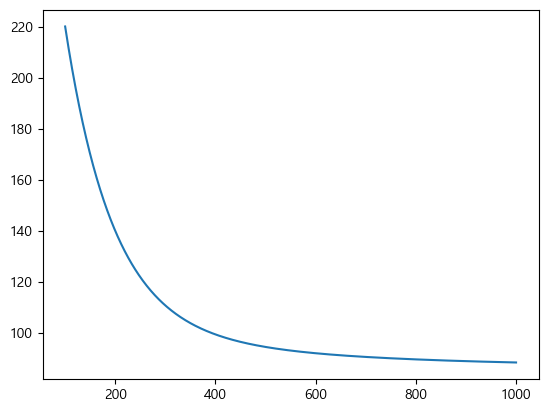

In [18]:
plt.plot(loss_data1)
plt.grid
plt.show()

In [19]:
# 해석
# 400번까지는 많이 감소하다가 그 이후는 많이 감소하지는 않음

In [20]:
# Q5는 지난시간에서 함. ols는 data frame을 가지고 해야함

## 1.2 ML 추정과 예측값 계산
- 지금까지 y 변수가 연속형일 때 분석을 배운 것임

In [22]:
# prediction of y: use ML (경사하강법)

In [23]:
X

array([[  4.25    ,  99.469   ,  42.912678,  93.25561 ],
       [  4.5     , 123.203   ,  43.94417 ,  94.82758 ],
       [  4.5     , 128.718   ,  44.42562 ,  94.      ],
       ...,
       [  1.25    , 113.7     ,  70.      ,  63.611317],
       [  1.25    ,  98.4     ,  70.      ,  63.602882],
       [  1.25    , 129.      ,  70.      ,  63.611485]], dtype=float32)

In [24]:
# Q: 두번째 가로의 예측값이 주어졌을 때 y hat이 얼마냐?
#        [  4.5     , 123.203   ,  43.94417 ,  94.82758 ],

In [25]:
second_row=X[1,:]
second_row

array([  4.5    , 123.203  ,  43.94417,  94.82758], dtype=float32)

In [26]:
predicted_y_ML=tf.matmul([second_row],W)+b
# 위에 loop 1000번 돌려서 W,랑 b값 나와있기 때문에, 여기서 W,b는 자동으로 그 중에 제일 마지막 값임
predicted_y_ML

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[86.72316]], dtype=float32)>

In [27]:
predicted_y_ML.numpy()

array([[86.72316]], dtype=float32)

In [29]:
# 86.723: 예측 결과

In [30]:
# second-row의 실제 y값
y[1,:]

array([88.06894], dtype=float32)

In [31]:
# 예측과 실제가 조금 차이남. ML에서 발생하는 실체와 예측 값의 차이

In [32]:
# Prediction of y: use OLS

In [34]:
housing_model=ols('API_TT0 ~ BaseRate1+IND_INDEX1+LTV2+DTI2',data=df3).fit()
print(housing_model.summary())

                            OLS Regression Results                            
Dep. Variable:                API_TT0   R-squared:                       0.369
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     160.4
Date:                Sat, 15 Jun 2024   Prob (F-statistic):          3.75e-108
Time:                        18:27:31   Log-Likelihood:                -3856.6
No. Observations:                1104   AIC:                             7723.
Df Residuals:                    1099   BIC:                             7748.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     72.1081      3.594     20.065      0.0

In [35]:
# seond row에 대한 y의 예측값을 계산해라 ols
second_row_ols=df3.iloc[1]
second_row_ols

API_TT0         88.068940
GU_CODE2      1111.000000
BaseRate         4.500000
IND_INDEX      128.718000
LTV             50.340131
DTI             95.151515
FREQ            99.000000
BaseRate1        4.500000
IND_INDEX1     123.203000
LTV2            43.944172
DTI2            94.827586
Name: 3, dtype: float64

In [36]:
df3.head()

,API_TT0,GU_CODE2,BaseRate,IND_INDEX,LTV,DTI,FREQ,BaseRate1,IND_INDEX1,LTV2,DTI2
2,81.208640,1111,4.5,123.203,44.425621,94.000000,90,4.25,99.469,42.912677,93.255607
3,88.068940,1111,4.5,128.718,50.340131,95.151515,99,4.50,123.203,43.944172,94.827586
4,86.507762,1111,4.5,110.893,50.951451,48.890836,68,4.50,128.718,44.425621,94.000000
5,91.769299,1111,4.5,102.227,51.251565,48.351863,48,4.50,110.893,50.340131,95.151515
6,92.079847,1111,5.0,108.332,52.053270,48.055339,55,4.50,102.227,50.951451,48.890836


In [38]:
predicted_y_ols=housing_model.predict(second_row_ols)
predicted_y_ols

3    88.716887
dtype: float64

In [41]:
# 예측값: 88.716
# 실제값: 88.068

In [42]:
# 오히려 ols가 ML보다 덜 차이남

In [43]:
# 지금까지 y 변수가 연속형일 때 분석을 배운 것임

## 1.3 이항종속변수 모형
- y 변수가 범주형인 경우를 배운다
- 범주가 2개인 경우 -> 이항종속변수모형